In [1]:
import os
import numpy as np
import sys
import h5py
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
sys.path.insert(0, os.path.abspath('../heart_rhythm_analysis'))    # make repo root importable

from heart_rhythm_analysis.get_data.CapnoBaseETL import CapnoBaseETL
from heart_rhythm_analysis.get_data.MimicAFETL import MimicAFETL


In [24]:
def load_as_df(file_path, filename, store_signals=True, bPlot=True):
    import h5py
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    h5_path = f"{file_path}/{filename}.h5"
    hf = h5py.File(h5_path, "r")

    rows = []
    for subj in hf.keys():
        subj_grp = hf[subj]
        for win_id in subj_grp.keys():
            win_grp = subj_grp[win_id]
            rec_id = win_grp.attrs['rec_id']
            label = win_grp.attrs['label']
            raw_ppg = win_grp["raw_ppg"][:]
            proc_ppg = win_grp["proc_ppg"][:]
            raw_ekg = win_grp["raw_ekg"][:]
            ekg_fs = win_grp.attrs["ekg_fs"]
            ppg_fs = win_grp.attrs["ppg_fs"]
            row_data = {
                "subject": subj,
                "window_id": win_id,
                "rec_id": rec_id,
                "label": label,
                "ppg_fs_out": ppg_fs,
                "ekg_fs_out": ekg_fs,
                "raw_len": len(raw_ppg),
                "proc_len": len(proc_ppg),
                "duration_raw_s": len(raw_ppg) / ppg_fs,
                "duration_proc_s": len(proc_ppg) / ppg_fs
            }
            
            if store_signals:
                row_data["raw_ppg"] = raw_ppg
                row_data["proc_ppg"] = proc_ppg
                row_data["raw_ekg"] = raw_ekg
            
            rows.append(row_data)

    # Build DataFrame
    df = pd.DataFrame(rows)
    print(f"\nTotal windows: {len(df)}")

    if bPlot:
        first = df.iloc[np.random.randint(0, len(df))]
        y = first["proc_ppg"]
        t = np.arange(len(y)) / first.ppg_fs_out

        fig = plt.figure(figsize=(15,7))
        plt.subplot(211)
        plt.plot(t, y)
        plt.title(f"Subject {first.subject} – Window {first.window_id}\nfs={first.ppg_fs_out} Hz")
        plt.xlabel("Time [s]")
        plt.ylabel("Amplitude")
        plt.xlim(0,10)

        plt.subplot(212)
        y = first["raw_ekg"]
        t = np.arange(len(y)) / first.ekg_fs_out
        plt.plot(t,y)
        plt.title(f"fs={first.ekg_fs_out} Hz")
        plt.xlim(0,10)
        plt.tight_layout()
        plt.show()
    hf.close()
    return df

# Create Capno Dataset

In [ ]:
# %autoreload 2



def main():
    root_path = os.path.join('../data/raw/capnobase/data/mat')
    out_path = os.path.join('../data/processed/length_full/capnobase_db')
    out_filename = 'capnobase_db'
    if not os.path.exists(out_path):
        os.mkdir(out_path)

    fs_in = 100.00
    fs_out = 20.83

    config = {
    "input_dir"      : root_path,
    "output_dir"     : out_path,
    "window_size_sec": 30,
    "fs_in"          : fs_in,
    "fs_out"   : fs_out,
    "lowpass_cutoff" : (fs_out / 2),
    "fir_numtaps"    : 129,
    "zero_phase"     : True,
    "out_filename" :  out_filename
}
    cfg = {'input_dir': root_path, 'output_dir': out_path}
    etl = CapnoBaseETL(config)
    h5file = etl.process_all()
    print(f"Saved windows HDF5 to {h5file}")
    df = load_as_df(out_path,out_filename)

    display(df.head(10))
    return df
if __name__ == "__main__":
    df_capnobase = main()

# MIMIC III AF DATASET

In [ ]:

def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_af_data.mat')
    out_filename = 'mimic_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename
    }
    
    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df

if __name__ == "__main__":
    df_mimc_af = main()
    

# MIMIC III Non-AF Dataset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/mimic_af_nonaf/mimic_non_af_data.mat')
    out_filename = 'mimic_non_af_db'
    out_path = os.path.join('../data/processed/length_full/mimic_non_af_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename   
    }

    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved non AF windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimc_nonaf = main()

# MIMIC III Ethnicity Subset

In [ ]:
def main():
    root_path = os.path.join('../data/raw/mimic_ethnicity_data/mimic_ethnicity_struct_output.mat')
    out_filename = 'mimic_ethnicity_db'
    out_path = os.path.join('../data/processed/length_full/mimic_ethnicity_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": 125.00,
        "fs_out": 20.83,
        "window_size_sec": 30,
        "scale_type": "norm",
        "zero_phase": True,
        "out_filename": out_filename 
    }
    
    etl = MimicAFETL(config)
    out_file = etl.process()
    print("Saved General MIMIC III - Ethnicity windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()

In [ ]:
all_subjects = df_mimic_gen['subject'].unique()
all_subjects

In [ ]:
df_capnobase['subject'].unique()
df_mimc_nonaf['subject'].unique()
df_mimc_nonaf['subject'].unique()
df_mimic_gen['subject'].unique()

# MIMIC IV AFib Data


Total windows: 2040


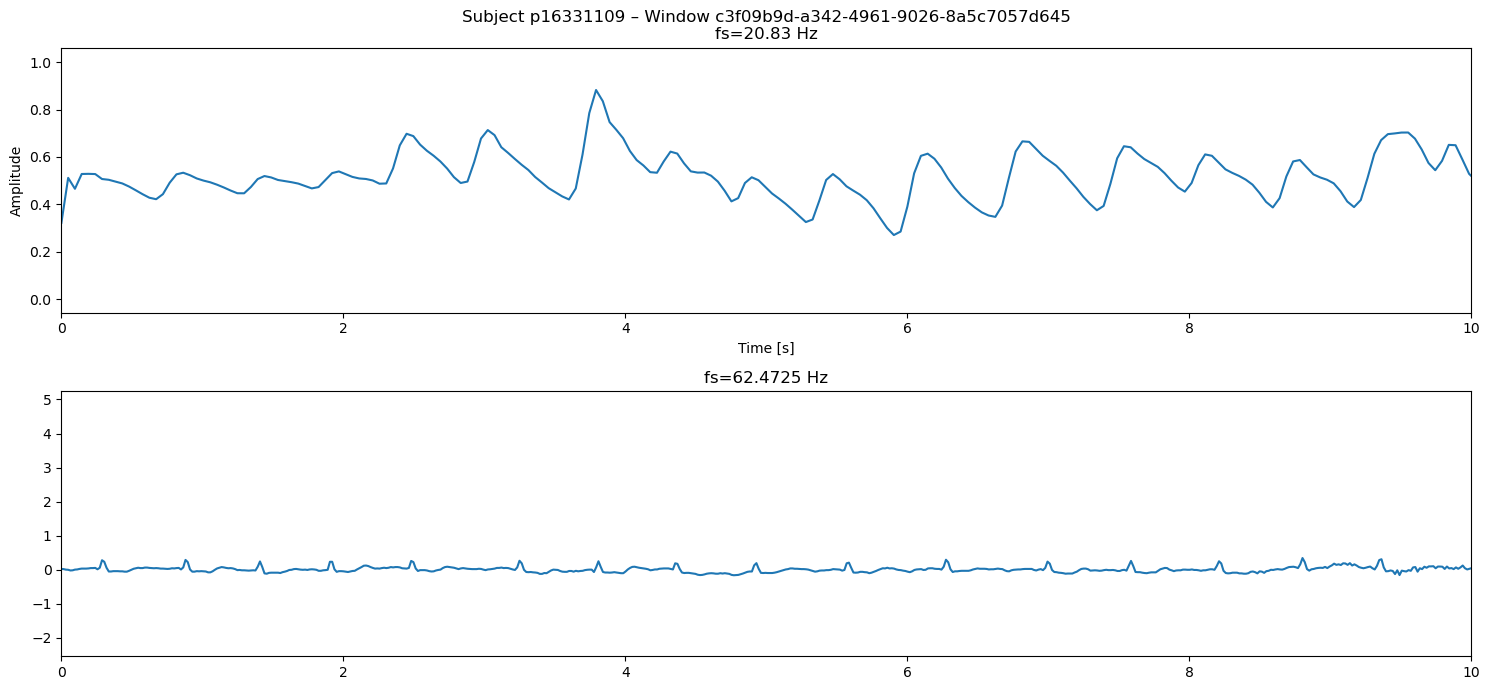

,subject,window_id,rec_id,label,ppg_fs_out,ekg_fs_out,raw_len,proc_len,duration_raw_s,duration_proc_s,raw_ppg,proc_ppg,raw_ekg
0,p10014354,0205b432-623f-4b4e-a4d7-814a59a350b6,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.642333984375, 0.63330078125, 0.6181640625, ...","[0.42659983, 0.650281, 0.50687504, 0.51184, 0....","[0.075, 0.06, 0.06, 0.07, 0.09, 0.11, 0.115, 0..."
1,p10014354,0a70110c-ebc3-4100-bbd5-d574cf662aa2,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.346923828125, 0.350341796875, 0.35693359375...","[0.23250943, 0.38892817, 0.35136446, 0.3501367...","[-0.135, -0.155, -0.175, -0.185, -0.155, -0.1,..."
2,p10014354,0eacac6e-d22d-4dc4-8643-a405fa87f1d8,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.482666015625, 0.515625, 0.57177734375, 0.63...","[0.3277603, 0.6724146, 0.75459903, 0.80108654,...","[-0.155, -0.175, -0.165, -0.18, -0.16, -0.065,..."
3,p10014354,1016f431-5c1d-4c5e-b080-969b32127204,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.42041015625, 0.417724609375, 0.419189453125...","[0.27918416, 0.454119, 0.4068637, 0.4186923, 0...","[0.125, 0.13, 0.115, 0.08, 0.03, 0.0, -0.025, ..."
4,p10014354,12966936-af0e-4d48-ad12-6535d3929d15,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.54541015625, 0.543701171875, 0.541259765625...","[0.36340326, 0.5816581, 0.5179351, 0.5576119, ...","[-0.16, 0.015, -0.015, -0.03, -0.015, -0.015, ..."
5,p10014354,1566675e-7b5b-4447-951c-0496f0840402,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.390625, 0.37744140625, 0.365966796875, 0.35...","[0.25620186, 0.39005807, 0.3387384, 0.36785397...","[-0.05, -0.09, -0.105, -0.12, -0.14, -0.15, -0..."
6,p10014354,15782395-e454-47bb-9b2c-997c04b0efdf,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.389404296875, 0.388916015625, 0.38842773437...","[0.25949788, 0.41881865, 0.38233122, 0.4478520...","[0.275, 0.0, -0.215, -0.01, 0.005, -0.015, -0...."
7,p10014354,1a55f087-d390-48ba-840d-7041ba57f7a3,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.271240234375, 0.266357421875, 0.26220703125...","[0.17942578, 0.28001574, 0.23420455, 0.2374215...","[0.02, -0.01, -0.025, -0.04, -0.05, -0.05, -0...."
8,p10014354,1cec2e60-433d-4c38-960f-d726a5ddd2ca,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.43359375, 0.43408203125, 0.433349609375, 0....","[0.28920734, 0.46629477, 0.40521678, 0.4262506...","[-0.125, -0.135, -0.145, -0.16, -0.17, -0.13, ..."
9,p10014354,1ff41dd7-dd6c-45e2-8e1a-ea861aa1ee1c,81739927_0008,-1,20.83,62.4725,1874,625,89.966395,30.004801,"[0.501220703125, 0.485107421875, 0.4658203125,...","[0.33006063, 0.48695672, 0.3910069, 0.4333921,...","[0.25, 0.245, 0.18, 0.075, -0.025, -0.085, -0...."


In [25]:
from heart_rhythm_analysis.get_data.MimicAFETL import MimicAFETL
np.random.seed(42)
def main():
    root_path = os.path.join('../data/raw/mimic4_data/mimic4_fibrillation_struct.mat')
    out_filename = 'mimic4_fibrillation_db'
    out_path = os.path.join('../data/processed/length_full/mimic4_fibrillation_db')
    
    if not os.path.exists(out_path):
        os.mkdir(out_path)
    fs_in = 62.4275
    fs_out = 20.83
    config = {
        "input_dir": root_path,
        "output_dir":  out_path,
        "fs_in": fs_in,
        "fs_out": fs_out,
        "window_size_sec": 30,
        "scale_type": None,
        "decimate_signal": None,
        "zero_phase": True,
        "out_filename": out_filename 
    }
    
    # etl = MimicAFETL(config)
    # out_file = etl.process()
    # print("Saved Atrial Fibrillation MIMIC IV  windows to", out_file)
    df = load_as_df(out_path,out_filename)
    display(df.head(10))
    return df
if __name__ == "__main__":
    df_mimic_gen = main()
